In [1]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# Denoising





Pour ce projet vous avez :

Pour le train
- Un dossier contenant des fichiers d'enregistrements de voix sans bruit (audio/voice_origin/train)
- Un dossier contenant des fichiers d'enregistrements de voix avec une ambiance de rue en arrière-plan (audio/denoising/train)
La correspondance entre un enregistrement avec ambiance et l'enregistrement parfait de la voix se fait via le nom des fichiers.

Pour l'ensemble de test vous avez deux ensembles de fichiers similaires.

Dans audio/voice_origin et audio/denoising vous avec un dossier train_small de petite taille que vous pouvez télécharger rapidement pour faire des essai.

L'objectif est d'estimer à partir du signal bruité le signal de voix.

Les signaux ont un SNR (Signal to Noise Ratio) compris entre 0 et 20 dB.

Vous pouvez au choix travailler
- sur le spectrogramme par exemple en vous des approches par masquage présentés dans le cours 09 et en estimant les masques avec un réseau Seq2Seq de votre choix ou un UNet (cf A. Jansson et Al., SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017 )
- directement sur la forme d'onde  :
   - cf D. Stoller  et Al., WAVE-U-NET: A MULTI-SCALE NEURAL NETWORK FOR END-TO-END AUDIO SOURCE SEPARATION, ISMIR 2018
   - les apporches TAS NEt : Y. Luo et Al., TaSNet: Time-Domain Audio Separation Network for Real-Time, Single-Channel Speech Separation, ICASSP 2018 ou Y. Luo et Al.,  Conv-tasnet: surpassing ideal time–frequency magnitude masking for speech separation. IEEE/ACM Transactions on Audio, Speech, and Language Processing, 2019.


Libre à vous de choisir la fonction de perte utilisée dans l’entraînement et adaptée au format des données que vous utiliserez en entrée du réseau de neurones.

Pour l'évaluation des performances sur l'ensemble de test, outre la fonction de perte vous vous intéresserez au PESQ et au STOI des voix estimées.  


In [2]:
path = "drive/MyDrive/MVA/DeepSignal/"

In [3]:
!pip install pySTOI
!pip install pesq

In [4]:
import os
import sys
import numpy as np
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd
import torchaudio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.io import wavfile
from scipy.io import wavfile
from pystoi import stoi
from pesq import pesq
import soundfile as sf

In [5]:
# !mkdir denoising
# !unzip drive/MyDrive/MVA/DeepSignal/denoising/test.zip -d denoising
# !unzip drive/MyDrive/MVA/DeepSignal/denoising/train.zip -d denoising
# !mkdir voice_origin
# !unzip drive/MyDrive/MVA/DeepSignal/voice_origin/test.zip -d voice_origin
# !unzip drive/MyDrive/MVA/DeepSignal/voice_origin/train.zip -d voice_origin

## Visualisation

In [6]:
# Import audio .wav file with scipy.io.wavfile.read

rate, data = scipy.io.wavfile.read('denoising/train/Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav')


# Listen to the audio file with IPython.display.Audio

ipd.Audio(data, rate=rate)


## Data

In [7]:
def normalize_waveform(waveform):
    # Normalize the waveform in the range [-1, 1]
    return waveform / np.max(np.abs(waveform))

class AudioDenoisingDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir):
        self.noisy_files = [os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir) if f.endswith('.wav')]
        self.clean_files = [os.path.join(clean_dir, f) for f in os.listdir(clean_dir) if f.endswith('.wav')]
        assert len(self.noisy_files) == len(self.clean_files), "Mismatch in dataset size"

    def __len__(self):
        return len(self.noisy_files)

    def __getitem__(self, idx):
        # Use scipy.io.wavfile.read to read the wav file
        noisy_rate, noisy_waveform = wavfile.read(self.noisy_files[idx])
        clean_rate, clean_waveform = wavfile.read(self.clean_files[idx])

        # convert clean_rate which is in int16 to float32
        clean_waveform = clean_waveform.astype(np.float32)
        noisy_waveform = noisy_waveform.astype(np.float32)

        # Apply normalization directly here
        noisy_waveform = normalize_waveform(noisy_waveform)
        clean_waveform = normalize_waveform(clean_waveform)

        return noisy_waveform, clean_waveform

In [8]:
train_dataset = AudioDenoisingDataset('denoising/train/', 'voice_origin/train/')
test_dataset = AudioDenoisingDataset('denoising/test/', 'voice_origin/test/')

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Batch 0:
  Input shape: torch.Size([32, 80000])
  Label shape: torch.Size([32, 80000])


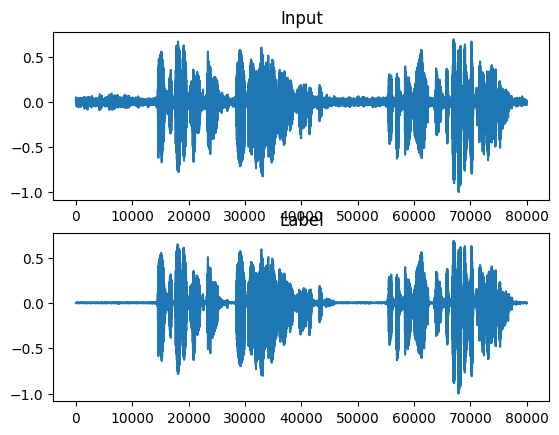

In [10]:
# Iterate over the DataLoader
for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i}:")
    print("  Input shape:", inputs.shape)
    print("  Label shape:", labels.shape)
    # Plot the first input and label in the batch
    plt.figure()
    plt.subplot(211)
    plt.title("Input")
    plt.plot(inputs[0, :])
    plt.subplot(212)
    plt.title("Label")
    plt.plot(labels[0, :])
    plt.show()
    if i == 0:  # Just to check the first batch as an example
        break

## Model

In [11]:
import torch
import torch.nn as nn

class DenoiseCNN(nn.Module):
    def __init__(self):
        super(DenoiseCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return x


# Create the U-Net model
model = DenoiseCNN()
print(model)


DenoiseCNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (conv2): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)


In [12]:
import torch
import torch.nn as nn

class DownsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=15, stride=1, padding=7, pool_size=2):
        super(DownsamplingBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.batchnorm = nn.BatchNorm1d(out_channels)  # Adding a batch normalization layer
        self.relu = nn.LeakyReLU(0.2)
        self.pool = nn.AvgPool1d(pool_size)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)  # Apply batch normalization after convolution
        skip = self.relu(x)
        # x = self.pool(skip)
        x = skip[:, :, ::2]
        return x, skip

class WaveUNetDownsampling(nn.Module):
    def __init__(self, channel_sizes=[1, 24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312]):
        super(WaveUNetDownsampling, self).__init__()
        self.downsampling_blocks = nn.ModuleList()
        for i in range(len(channel_sizes) - 1):
            block = DownsamplingBlock(channel_sizes[i], channel_sizes[i+1])
            self.downsampling_blocks.append(block)

    def forward(self, x):
        skip_connections = [x]
        for block in self.downsampling_blocks:
            x, skip = block(x)
            skip_connections.append(skip)
        return x, skip_connections[::-1]


In [13]:
class UpsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1, padding=2):
        super(UpsamplingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.batchnorm = nn.BatchNorm1d(out_channels)  # Adding a batch normalization layer
        self.relu = nn.LeakyReLU(0.2)


    def forward(self, x, skip_connection):
        x = self.upsample(x)
        x = torch.cat((x, skip_connection), 1)
        x = self.conv(x)
        x = self.batchnorm(x)  # Apply batch normalization after convolution
        self.relu = nn.LeakyReLU(0.2)
        return x

class WaveUNetUpsampling(nn.Module):
    def __init__(self, channel_sizes=[336, 312, 288, 264, 240, 216, 192, 168, 144, 120, 96, 72, 48, 24]):
        super(WaveUNetUpsampling, self).__init__()
        self.upsampling_blocks = nn.ModuleList()
        for i in range(len(channel_sizes)-1):
            in_channels = channel_sizes[i+1] + channel_sizes[i]
            out_channels = channel_sizes[i+1]
            block = UpsamplingBlock(in_channels, out_channels)
            self.upsampling_blocks.append(block)

    def forward(self, x, skip_connections):
        for i, block in enumerate(self.upsampling_blocks):
            x = block(x, skip_connections[i])
        return x

class WaveUNet(nn.Module):
    def __init__(self):
        super(WaveUNet, self).__init__()
        self.downsampling = WaveUNetDownsampling()
        self.bottleneck = nn.Conv1d(312, 336, kernel_size=15, padding=7)
        self.upsampling = WaveUNetUpsampling()
        self.final_conv = nn.Conv1d(in_channels=25, out_channels=1, kernel_size=1)
        self.tanh = nn.Tanh()

    def forward(self, x ):
        desired_length = 2**16  # 65,536
        x = x[:, :, :desired_length]
        x, skip_connections = self.downsampling(x)
        x = self.bottleneck(x)
        x = self.upsampling(x, skip_connections)
        x = self.final_conv(torch.cat((x, skip_connections[-1]), 1))
        x = self.tanh(x)
        return x


In [14]:
# Check if CUDA is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
model = WaveUNet().to(device)

criterion = nn.MSELoss()

# Select an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
import time
import torch

epochs = 30  # Number of epochs
best_val_loss = float('inf')  # Initialize the best validation loss as infinity
start_time = time.time()

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in train_loader:
        inputs, targets = batch

        inputs = inputs.unsqueeze(1).to(device)
        targets = targets.unsqueeze(1).to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        desired_length = 2**16  # 65,536
        targets = targets[:, :, :desired_length]
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)

    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # No need to track the gradients
        for batch in val_loader:
            inputs, targets = batch

            inputs = inputs.unsqueeze(1).to(device)
            targets = targets.unsqueeze(1).to(device)

            # Forward pass
            outputs = model(inputs)
            targets = targets[:, :, :desired_length]
            loss = criterion(outputs, targets)

            total_loss += loss.item()

    val_loss = total_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{epochs} - time: {time.time()-start_time:.2f} - Training Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}")

    # Save the model if the validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'denoise_cnn.pt')
        print(f"Model saved at epoch {epoch+1} with validation loss: {best_val_loss:.8f}")


Epoch 1/30 - time: 65.09 - Training Loss: 0.00508423, Validation Loss: 0.00153859
Model saved at epoch 1 with validation loss: 0.00153859
Epoch 2/30 - time: 129.75 - Training Loss: 0.00113016, Validation Loss: 0.00104496
Model saved at epoch 2 with validation loss: 0.00104496
Epoch 3/30 - time: 195.79 - Training Loss: 0.00099844, Validation Loss: 0.00096618
Model saved at epoch 3 with validation loss: 0.00096618
Epoch 4/30 - time: 261.89 - Training Loss: 0.00094333, Validation Loss: 0.00090532
Model saved at epoch 4 with validation loss: 0.00090532
Epoch 5/30 - time: 328.15 - Training Loss: 0.00093132, Validation Loss: 0.00085957
Model saved at epoch 5 with validation loss: 0.00085957
Epoch 6/30 - time: 394.64 - Training Loss: 0.00088563, Validation Loss: 0.00084662
Model saved at epoch 6 with validation loss: 0.00084662
Epoch 7/30 - time: 461.09 - Training Loss: 0.00087394, Validation Loss: 0.00081442
Model saved at epoch 7 with validation loss: 0.00081442
Epoch 8/30 - time: 527.99 - 

In [33]:
# Load the trained model
model = WaveUNet()
model.load_state_dict(torch.load('denoise_cnn.pt'))
model.eval()

example_file = "Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap03_100_.wav"
rate, input = scipy.io.wavfile.read('/content/denoising/test/'+example_file)

rate, target = scipy.io.wavfile.read('/content/voice_origin/test/'+example_file)


input = torch.from_numpy(input)
input = input.unsqueeze(0)
input = input.unsqueeze(0)

prediction = model(input)
prediction = prediction.squeeze(0).squeeze(0)

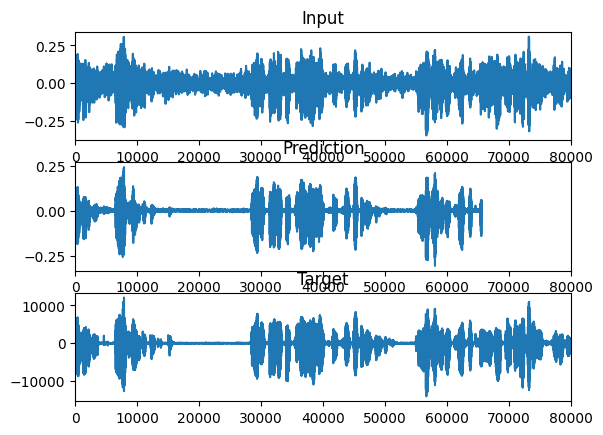

In [42]:
plt.figure()
plt.subplot(311)
plt.title("Input")
plt.plot(input.squeeze(0).squeeze(0).cpu())
plt.xlim(0, 80000)
plt.subplot(312)
plt.title("Prediction")
plt.plot(prediction.detach().numpy())
plt.xlim(0, 80000)
plt.subplot(313)
plt.title("Target")
plt.plot(target)
plt.xlim(0, 80000)
plt.show()

In [35]:
# Listen to the input, prediction and target
ipd.Audio(input.squeeze(0).squeeze(0).numpy(), rate=rate)

In [36]:
ipd.Audio(prediction.detach().numpy(), rate=rate)

In [39]:
audio_data = prediction.detach().numpy()
wavfile.write('output_audio.wav', rate, audio_data)

In [37]:
ipd.Audio(target, rate=rate)


In [22]:
model = WaveUNet().to(device)
model.load_state_dict(torch.load('denoise_cnn.pt'))
model.eval()


WaveUNet(
  (downsampling): WaveUNetDownsampling(
    (downsampling_blocks): ModuleList(
      (0): DownsamplingBlock(
        (conv): Conv1d(1, 24, kernel_size=(15,), stride=(1,), padding=(7,))
        (batchnorm): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.2)
        (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
      )
      (1): DownsamplingBlock(
        (conv): Conv1d(24, 48, kernel_size=(15,), stride=(1,), padding=(7,))
        (batchnorm): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.2)
        (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
      )
      (2): DownsamplingBlock(
        (conv): Conv1d(48, 72, kernel_size=(15,), stride=(1,), padding=(7,))
        (batchnorm): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slo

In [32]:
stoi_originals,stoi_preds, pesq_originals, pesq_preds = [], [], [], []
stop = 200
for i, (input, target) in enumerate(test_dataset):
    if i==stop:
        break
    input = torch.from_numpy(input).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(input)
        desired_length = 2**16  # 65,536

        target = target[:desired_length]
        input = input[:,:,:desired_length]

        stoi_originals.append(stoi(target, input.squeeze(0).squeeze(0).cpu().numpy(), rate))
        stoi_preds.append(stoi(target, prediction.squeeze(0).squeeze(0).cpu().numpy(), rate))
        pesq_originals.append(pesq(rate, target, input.squeeze(0).squeeze(0).cpu().numpy(), 'nb'))
        pesq_preds.append(pesq(rate, target, prediction.squeeze(0).squeeze(0).cpu().numpy(), 'nb'))
stoi_diffs = [a - b for a, b in zip(stoi_preds, stoi_originals)]  # >0 is better
pesq_diffs = [a - b for a, b in zip(pesq_preds, pesq_originals)]  # >0 is better

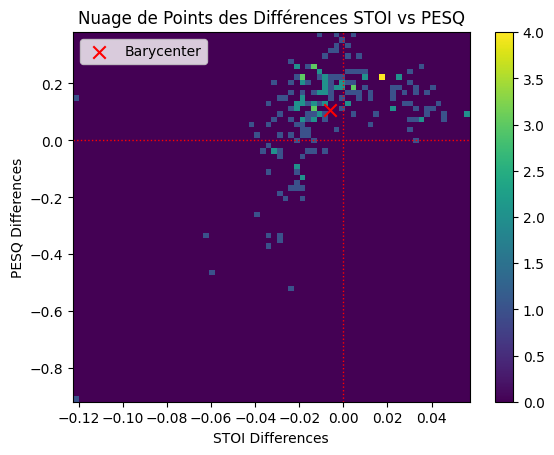

In [38]:
plt.hist2d(stoi_diffs, pesq_diffs, bins=(70, 70), cmap='viridis')

# Add colorbar
plt.colorbar()
# plt.xlim(-0.04, 0.05)  # Set the x-axis limits
# plt.ylim(-0.1, 0.7)  # Set the y-axis limits
# Set labels and title
plt.xlabel('STOI Differences')
plt.ylabel('PESQ Differences')
plt.title('Nuage de Points des Différences STOI vs PESQ')
plt.axhline(0, color='red', linestyle=':', linewidth=1)
plt.axvline(0, color='red', linestyle=':', linewidth=1)
plt.scatter(np.mean(stoi_diffs), np.mean(pesq_diffs), c='red', marker='x', label='Barycenter', s=80)
plt.legend()
# Show the plot
plt.show()